In [31]:
import json
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
# Constants

figsize = (10,6)
pktPayloadSize = 1460 # Bytes
hdrSize = 40 #Bytes
torBw = 10e9 # bps
coreBw = 40e9 # bps

oneWayDel = 1.0e-6 \
         + (pktPayloadSize+hdrSize)*8*(2/torBw + 2/coreBw)
baseRtt = oneWayDel \
         + 1.0e-6 + 64*8*(2/torBw + 2/coreBw)

bdpPkts = 7

saturationTime = 3.1

In [33]:
# Helpers

def removeKey(d, key):
    r = dict(d)
    del r[key]
    return r

def getPctl(a, p):
    i = int(len(a) * p)
    return a[i]

In [34]:
# filenames = ["trace/MsgTraces_different_1.tr", "trace/MsgTraces_same_1.tr"] 
# filenames = ["trace/different-MsgTraces_W5_load-50p_0.tr"]
# filenames = ["trace/MsgTraces_W5_load-80p_0_dynamic.tr"]

# filenames = ["trace/different-MsgTraces_W5_load-50p_0.tr", "trace/MsgTraces_W5_load-80p_0_dynamic.tr"]
# filenames = ["trace/MsgTraces_W5_load-80p_7_144.tr", "trace/different-MsgTraces_W5_load-50p_0.tr", "trace/MsgTraces_W5_load-80p_0_dynamic.tr"]

# filenames = ['trace/MsgTraces_W5_load-80p_7_8.tr']

# filenames = ['trace/MsgTraces_W5_load-80p_dynamic_8.tr', 'trace/MsgTraces_W5_load-80p_dynamic_144.tr']
# filenames = ['trace/MsgTraces_W5_load-100p_7_8.tr', 'trace/MsgTraces_W5_load-100p_7_144.tr']
# filenames = ['trace/MsgTraces_W5_load-80p_dynamic_8.tr', 'trace/MsgTraces_W5_load-80p_dynamic_144.tr']

# filenames = ["trace/MsgTraces_W5_load-100p_0_24hr_7bdp_144node.tr"]
# filenames = ["trace/MsgTraces_W5_load-100p_0_1toall_8nodes_7bdp.tr"]

# filenames = ["trace/MsgTraces_W5_load-100p_0_24hr_7bdp_144node.tr","trace/MsgTraces_W5_load-100p_0_1toall_8nodes_7bdp.tr"]
# filenames = ['trace/MsgTraces_W5_load-100p_0.tr', 'trace/MsgTraces_W5_load-100p_1.tr', 'trace/MsgTraces_W5_load-100p_dynamic_new_24h_144.tr', "trace/MsgTraces_W5_load-100p_0_24hr_7bdp_144node.tr"]


filenames = ['trace/MsgTraces_W5_load-100p_dynamic_new_24h_144.tr', "trace/MsgTraces_W5_load-100p_0_24hr_7bdp_144node.tr"]

In [35]:
colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"]

In [36]:

# Verify filename matches format: trace/MsgTraces_W5_load-80p_7_8.tr
def verifyFilename(filename):
    if filename[:18] != "trace/MsgTraces_W5":
        print("Filename does not match format: MsgTraces_W5")
        return False
    if filename[-3:] != ".tr":
        print("Filename does not match format: .tr")
        return False
    return True

def getLoad(filename):
    return filename.split("_")[2].split("-")[1][:-1]

def getBDP(filename):
    return filename.split("_")[3]

def getNumNodes(filename):
    return filename.split("_")[4][:-3]


In [37]:
file_num_nodes = []
file_network_load = []
file_bdp = []

for i, filename in enumerate(filenames):
    num_nodes = 0
    networkLoad = 0
    bdp = "0"
    
    if verifyFilename(filename):
        try:
            num_nodes = int(getNumNodes(filename))
            networkLoad = float(getLoad(filename))/100
            bdp = getBDP(filename)
        except:
            print("Error parsing filename: " + filename)
    
    file_num_nodes.append(num_nodes)
    file_network_load.append(networkLoad)
    file_bdp.append(bdp)

Error parsing filename: trace/MsgTraces_W5_load-100p_dynamic_new_24h_144.tr


In [38]:
fileMsgStartEntryDict = []
fileMsgCompletionTimesDict = []
fileAllMsgSizes = []
fileMsgSizePercentiles = []

fileMsgCompletionTimesDictSameSwitch = []
fileMsgCompletionTimesDictDiffSwitch = []

In [39]:
for i, filename in enumerate(filenames):
    print(i, filename)

    # Dict of start time
    msgStartEntryDict = {}
    # Dict of completion time
    msgCompletionTimesDict = {}
    # List of all message sizes
    allMsgSizes = []

    msgCompletionTimesDictSameSwitch = {}
    msgCompletionTimesDictDiffSwitch = {}

    # For 144 nodes 16 switches
    def isSameSwitch(sender, receiver, numSwitches):
        # senderSwitchNum = int(sender.split(".")[2]) // numSwitches
        # receiverSwitchNum = int(receiver.split(".")[2]) // numSwitches
        # return senderSwitchNum == receiverSwitchNum
        # print(sender, receiver)
        senderPortNum = (int(sender.split(":")[1]) - 1000) // numSwitches
        receiverPortNum = (int(receiver.split(":")[1]) - 1000) // numSwitches
        # print(senderPortNum, receiverPortNum)
        return senderPortNum == receiverPortNum


    with open(filename,'r') as f:
        for line in f:
            msgLog = line.split()

            time = float(msgLog[1])*1e-9        # in seconds
            msgSize = int(msgLog[2])            # in bytes
            sender = msgLog[3]                  # ip:port
            receiver = msgLog[4]                # ip:port
            txMsgId = int(msgLog[5])

            key = (sender, receiver, txMsgId, i)

            # Skip warmup messages
            if msgSize == 10:
                continue

            # Sender
            if (msgLog[0]=='+'):
                if (key in msgStartEntryDict):
                    msgStartEntryDict[key].append(time)
                else:
                    # Create new entry if not in dict
                    msgStartEntryDict[key] = [time]
            # Receiver
            elif (msgLog[0] =='-'):
                if (key in msgStartEntryDict):
                    # Find matching start entry
                    startTime = msgStartEntryDict[key].pop()

                    # Remove from startEntryDict (message completed)
                    if (len(msgStartEntryDict[key]) <= 0):
                        msgStartEntryDict = removeKey(msgStartEntryDict, key)

                    # Invalid
                    if(startTime < saturationTime):
                        continue
                    
                    # Valid
                    if (msgSize in msgCompletionTimesDict):
                        msgCompletionTimesDict[msgSize].append(time-startTime)
                    else:
                        # Create entry if not in dict
                        msgCompletionTimesDict[msgSize] = [time-startTime]

                    # Same switch
                    if (isSameSwitch(sender, receiver, 9)):
                        if (msgSize in msgCompletionTimesDictSameSwitch):
                            msgCompletionTimesDictSameSwitch[msgSize].append(time-startTime)
                        else:
                            # Create entry if not in dict
                            msgCompletionTimesDictSameSwitch[msgSize] = [time-startTime]
                    # Different switch
                    else:
                        if (msgSize in msgCompletionTimesDictDiffSwitch):
                            msgCompletionTimesDictDiffSwitch[msgSize].append(time-startTime)
                        else:
                            # Create entry if not in dict
                            msgCompletionTimesDictDiffSwitch[msgSize] = [time-startTime]

                    # Add to list of all message sizes
                    allMsgSizes.append(msgSize)
                else:
                    print('ERROR: Start entry of message (' \
                        + sender + ' > ' + receiver + ', ' + str(txMsgId) \
                        + ') not found!')
                    
    allMsgSizes = np.array(allMsgSizes)
    msgSizePercentiles = stats.rankdata(allMsgSizes, 'max')/len(allMsgSizes)*100

    fileMsgStartEntryDict.append(msgStartEntryDict)
    fileMsgCompletionTimesDict.append(msgCompletionTimesDict)
    fileAllMsgSizes.append(allMsgSizes)
    fileMsgSizePercentiles.append(msgSizePercentiles)

    fileMsgCompletionTimesDictSameSwitch.append(msgCompletionTimesDictSameSwitch)
    fileMsgCompletionTimesDictDiffSwitch.append(msgCompletionTimesDictDiffSwitch)

0 trace/MsgTraces_W5_load-100p_dynamic_new_24h_144.tr


1 trace/MsgTraces_W5_load-100p_0_24hr_7bdp_144node.tr


In [54]:
for i, filename in enumerate(filenames):
    print(i, filename)
    # Print same switch number of messages
    total_count = 0
    for key in fileMsgCompletionTimesDictSameSwitch[i]:
        total_count += len(fileMsgCompletionTimesDictSameSwitch[i][key])
    print("Same switch: " + str(total_count))

    # Print different switch number of messages
    total_count = 0
    for key in fileMsgCompletionTimesDictDiffSwitch[i]:
        total_count += len(fileMsgCompletionTimesDictDiffSwitch[i][key])
    
    print("Different switch: " + str(total_count))

print()

for i, filename in enumerate(filenames):
    print(i , filename)

    total_throughput = 0
    for msgSize in fileMsgCompletionTimesDictSameSwitch[i]:
        # if total_throughput == 0:
        #     print(msgSize, fileMsgCompletionTimesDictSameSwitch[i][msgSize])
        total_throughput += msgSize * len(fileMsgCompletionTimesDictSameSwitch[i][msgSize]) / sum(fileMsgCompletionTimesDictSameSwitch[i][msgSize])
        

    # Convert from bytes/ns to bytes/s
    # total_throughput = total_throughput * 1e9

    # Convert from bytes/s to Gbps
    total_throughput = total_throughput * 10e-9 / 144

    print("Same switch throughput: " + str(total_throughput))

    total_throughput = 0
    for msgSize in fileMsgCompletionTimesDictDiffSwitch[i]:
        total_throughput += msgSize * len(fileMsgCompletionTimesDictDiffSwitch[i][msgSize]) / sum(fileMsgCompletionTimesDictDiffSwitch[i][msgSize])

    # Convert from bytes/ns to bytes/s
    # total_throughput = total_throughput * 1e9

    # Convert from bytes/s to Gbps
    total_throughput = total_throughput * 10e-9 / 144

    print("Different switch throughput: " + str(total_throughput))


    

0 trace/MsgTraces_W5_load-100p_dynamic_new_24h_144.tr
Same switch: 1963
Different switch: 33498
1 trace/MsgTraces_W5_load-100p_0_24hr_7bdp_144node.tr
Same switch: 1512
Different switch: 25932

0 trace/MsgTraces_W5_load-100p_dynamic_new_24h_144.tr
Same switch throughput: 5.319318183340085
Different switch throughput: 7.750715901907968
1 trace/MsgTraces_W5_load-100p_0_24hr_7bdp_144node.tr
Same switch throughput: 5.95267367877736
Different switch throughput: 7.14431187797979


In [41]:
# Basic stats

for i, filename in enumerate(filenames):
    print("\n", i, filename)

    # Items remaining in startEntryDict were uncompleted
    numUncompleted = 0
    for msgKey, msgStartTimes in fileMsgStartEntryDict[i].items():
        numUncompleted += len(msgStartTimes)

    print('Number of uncompleted messages: ' + str(numUncompleted))
    print('Number of distinct message sizes: ' + str(len(fileMsgCompletionTimesDict[i])))

    cntMultMeasures = 0
    numMsgs = 0
    nonFullPacketMsgSizes = []
    for msgSize, msgCompletionTimes in fileMsgCompletionTimesDict[i].items():
        # Count number of distinct message sizes that have multiple measurements
        if (len(msgCompletionTimes)>1):
            cntMultMeasures += 1

        # Count number of distinct messages
        numMsgs += len(msgCompletionTimes)
        
        # Count number of non-full packet messages
        if (msgSize%pktPayloadSize != 0):
            # print(msgSize%1452)
            # Dynamic packets are 1452, not 1460, so this is expected
            nonFullPacketMsgSizes.append((msgSize,msgSize%pktPayloadSize))
        
    print('Number of distinct message sizes that have multiple measurements: ' + str(cntMultMeasures))   
    print('Number of distinct messages: ' + str(numMsgs)) 

    if (nonFullPacketMsgSizes):
        print('Non-Full Packet Message Sizes: ', nonFullPacketMsgSizes)


 0 trace/MsgTraces_W5_load-100p_dynamic_new_24h_144.tr
Number of uncompleted messages: 1112
Number of distinct message sizes: 400
Number of distinct message sizes that have multiple measurements: 399
Number of distinct messages: 35461
Non-Full Packet Message Sizes:  [(229100, 1340), (23200, 1300), (967150, 630), (65250, 1010), (813450, 230), (2900, 1440), (1450, 1450), (66700, 1000), (69600, 980), (4687850, 1250), (60900, 1040), (14500, 1360), (2730350, 150), (1161450, 750), (26100, 1280), (63800, 1020), (1474650, 50), (73950, 950), (4350, 1430), (46400, 1140), (13050, 1370), (72500, 960), (53650, 1090), (7250, 1410), (108750, 710), (4325350, 830), (98600, 780), (56550, 1070), (3527850, 490), (31900, 1240), (21750, 1310), (281300, 980), (2077850, 270), (169650, 290), (4832850, 250), (8700, 1400), (5800, 1420), (1136800, 920), (1064300, 1420), (3600350, 1450), (600300, 240), (2440350, 690), (10150, 1390), (124700, 600), (145000, 460), (20300, 1320), (52200, 1100), (58000, 1060), (43978

In [42]:
FileSimMsgSizes = []
FileSimP50CompletionTimes = []
FileSimP99CompletionTimes = []
FileSimBaseCompletionTimes = []
FileSimP50SlowDowns = []
FileSimP99SlowDowns = []

In [43]:
# Get slowdowns

for i, filename in enumerate(filenames):
    print("\n", i, filename)

    SimMsgSizes = []
    SimP50CompletionTimes = []
    SimP99CompletionTimes = []
    SimBaseCompletionTimes = []
    SimP50SlowDowns = []
    SimP99SlowDowns = []

    for msgSize, msgCompletionTimes in fileMsgCompletionTimesDict[i].items():
        
        SimMsgSizes.append(msgSize)
        
        times = np.array(msgCompletionTimes)
        p50CompletionTime = np.percentile(times,50)
        SimP50CompletionTimes.append(p50CompletionTime)
        p99CompletionTime = np.percentile(times,99)
        SimP99CompletionTimes.append(p99CompletionTime)
        
        totBytes = msgSize + math.ceil(msgSize / pktPayloadSize) * (hdrSize) 
        baseCompletionTime = totBytes * 8 / torBw;
        if (msgSize > bdpPkts * pktPayloadSize):
            baseCompletionTime += oneWayDel#baseRtt
        else:
            baseCompletionTime += oneWayDel
    #     baseCompletionTime = (msgSize+pktPayloadSize)*8.0/10e9 + 0.5e-6 \
    #                           + 2*pktPayloadSize*8.0/40e9 + 0.5e-6
        
        SimBaseCompletionTimes.append(baseCompletionTime)
        
        SimP50SlowDowns.append(p50CompletionTime / baseCompletionTime)
        SimP99SlowDowns.append(p99CompletionTime / baseCompletionTime)

    #     slowDowns = times / baseCompletionTime
    #     slowDowns = np.where(slowDowns < 1.0, 1.0, slowDowns)

    #     SimP50SlowDowns.append(np.percentile(slowDowns,50))
    #     SimP99SlowDowns.append(np.percentile(slowDowns,99))
        
    zipData = sorted(zip(SimMsgSizes,
                        SimP50CompletionTimes,
                        SimP99CompletionTimes,
                        SimBaseCompletionTimes,
                        SimP50SlowDowns,
                        SimP99SlowDowns))
        
    SimMsgSizes = np.array([x for x,_,_,_,_,_ in zipData])
    SimP50CompletionTimes = np.array([x for _,x,_,_,_,_ in zipData])
    SimP99CompletionTimes = np.array([x for _,_,x,_,_,_ in zipData])
    SimBaseCompletionTimes = np.array([x for _,_,_,x,_,_ in zipData])
    SimP50SlowDowns = np.array([x for _,_,_,_,x,_ in zipData])
    SimP99SlowDowns = np.array([x for _,_,_,_,_,x in zipData])

    FileSimMsgSizes.append(SimMsgSizes)
    FileSimP50CompletionTimes.append(SimP50CompletionTimes)
    FileSimP99CompletionTimes.append(SimP99CompletionTimes)
    FileSimBaseCompletionTimes.append(SimBaseCompletionTimes)
    FileSimP50SlowDowns.append(SimP50SlowDowns)
    FileSimP99SlowDowns.append(SimP99SlowDowns)


 0 trace/MsgTraces_W5_load-100p_dynamic_new_24h_144.tr



 1 trace/MsgTraces_W5_load-100p_0_24hr_7bdp_144node.tr


In [44]:
maxSize = 0
for i, filename in enumerate(filenames):
    # Get max size of each file
    for msgSize in fileMsgCompletionTimesDict[i].keys():
        if (msgSize > maxSize):
            maxSize = msgSize

# Create 10 xticks from 0 to maxsize
xticks = np.arange(0, maxSize+1, maxSize/10)


In [45]:
def moving_average(data, window_size):
    return pd.Series(data).rolling(window=window_size).mean()

In [46]:
def plot_file(i, ax, window_size=50, plot_avg=False, only50=False, only99=False):
    x = [fileMsgSizePercentiles[i][np.where(fileAllMsgSizes[i] == msgsize)[0][0]] for msgsize in FileSimMsgSizes[i]]
    # x = [fileMsgSizePercentiles[i][np.where(fileAllMsgSizes[i] == msgsize)[0][0]] for msgsize in FileSimMsgSizes[i]]
    x = FileSimMsgSizes[i]
    y50 = FileSimP50SlowDowns[i]
    y99 = FileSimP99SlowDowns[i]

    # Calculate moving averages
    moving_avg_50 = moving_average(y50, window_size=window_size)
    moving_avg_99 = moving_average(y99, window_size=window_size)

    label = f'{file_num_nodes[i]}nodes_{file_network_load[i]}load_{file_bdp[i]}pkts'

    plot_both = not only50 and not only99
    if not plot_avg:
        if only50 or plot_both: ax.step(x, y50, label=f'{label} 50%', color=colors[i], linestyle='--')
        if only99 or plot_both: ax.step(x, y99, label=f'{label} 99%', color=colors[i])

    # Plot moving averages
    if plot_avg:
        if only50 or plot_both: ax.plot(x, moving_avg_50, label=f'{label} 50%', color=colors[i])
        if only99 or plot_both: ax.plot(x, moving_avg_99, label=f'{label} 99%', color=colors[i])

    # Existing plotting code...
    # ax.ylabel('Slow Down')
    # ax.xlabel('Message Size (Bytes)')
    # ax.title(f'Homa Message Completion Slowdown for {file_num_nodes[i]} Nodes with {file_network_load[i]*100}% Load')
    # ax.legend(loc='upper left')
    # ----------------------------------------------

    # xTickPercentiles = np.linspace(10, 100, 10)
    # # xticks = np.percentile(fileAllMsgSizes[i],xTickPercentiles).astype(int) 
    # # xticks = np.percentile(maxSize,xTickPercentiles).astype(int) 
    # # Give list of xticks where each xtick is percentage of maxSize, 10%, 20%, etc
    # xticks = np.logspace(start=0, stop=np.log10(maxSize), num=10, endpoint=True)


    # # plt.xticks(xTickPercentiles, xticks, rotation=45)

    # # xticks = np.percentile(maxSize,xTickPercentiles).astype(int) 
    # plt.xticks(xTickPercentiles, xticks, rotation=45)

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    # plt.tight_layout()


 0 trace/MsgTraces_W5_load-100p_dynamic_new_24h_144.tr

 1 trace/MsgTraces_W5_load-100p_0_24hr_7bdp_144node.tr


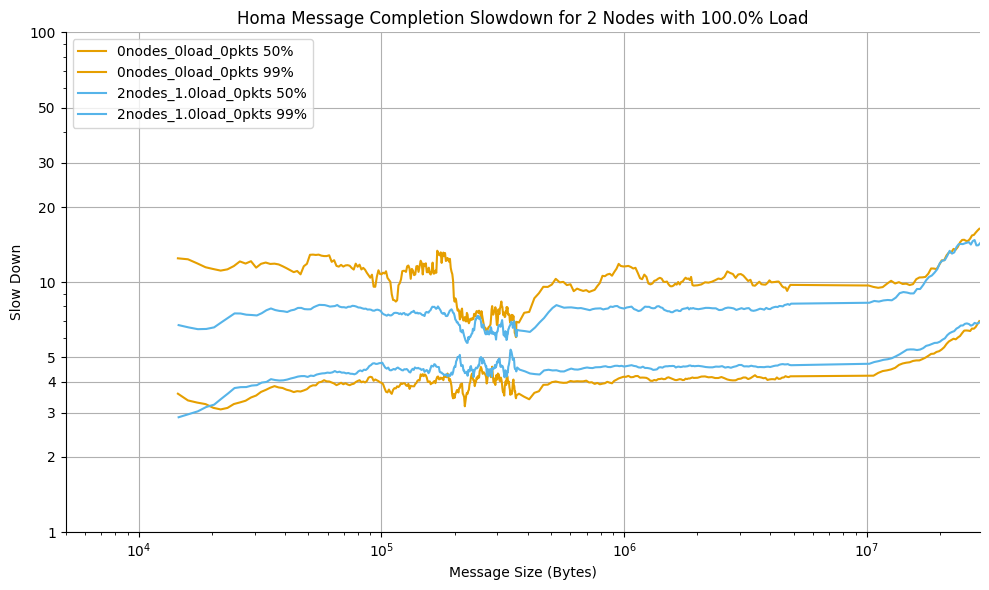

In [47]:
fig, ax = plt.subplots(figsize=figsize)
# ax.ylabel('Slow Down')
# ax.xlabel('Message Size (Bytes)')
# ax.title(f'Homa Message Completion Slowdown for {file_num_nodes[i]} Nodes with {file_network_load[i]*100}% Load')
# ax.legend(loc='upper left')
ax.set_ylabel('Slow Down')
ax.set_xlabel('Message Size (Bytes)')
ax.set_title(f'Homa Message Completion Slowdown for {file_num_nodes[i]} Nodes with {file_network_load[i]*100}% Load')
ax.grid(True, which='major', axis='both')

for i, filename in enumerate(filenames):
    print("\n", i, filename)
    plot_file(i, ax, window_size=10, plot_avg=True)  # Pass the ax object here

ax.set_yscale('log')
ax.set_ylim([1,100])
yticks = [1,2,3,4,5,10,20,30,50,100]
ax.set_yticks(yticks)

# Put labels on y axis
ax.set_yticklabels(yticks)

# xlim of 5000 to inf
ax.set_xlim([5000, maxSize])

ax.set_xscale('log')

ax.legend(loc='upper left')
# Remove plt.tight_layout() from the function and call it here
plt.tight_layout()
plt.show()

In [48]:
for i, filename in enumerate(filenames):
    # print mean of 50% and 99% slowdowns
    print(i, filename)
    print("50% slowdown mean: ", np.mean(FileSimP50SlowDowns[i]))
    print("99% slowdown mean: ", np.mean(FileSimP99SlowDowns[i]))
    # print("50% slowdown median: ", np.median(FileSimP50SlowDowns[i]))
    # print("99% slowdown median: ", np.median(FileSimP99SlowDowns[i]))
    print("50% slowdown std: ", np.std(FileSimP50SlowDowns[i]))
    print("99% slowdown std: ", np.std(FileSimP99SlowDowns[i]))
    # print("50% slowdown max: ", np.max(FileSimP50SlowDowns[i]))
    # print("99% slowdown max: ", np.max(FileSimP99SlowDowns[i]))
    # print("50% slowdown min: ", np.min(FileSimP50SlowDowns[i]))
    # print("99% slowdown min: ", np.min(FileSimP99SlowDowns[i]))


0 trace/MsgTraces_W5_load-100p_dynamic_new_24h_144.tr
50% slowdown mean:  4.150962109128594
99% slowdown mean:  10.056993311113597
50% slowdown std:  0.8966018989899921
99% slowdown std:  3.4636151781124087
1 trace/MsgTraces_W5_load-100p_0_24hr_7bdp_144node.tr
50% slowdown mean:  4.645704409144738
99% slowdown mean:  7.818235219759197
50% slowdown std:  0.847149611835184
99% slowdown std:  1.9842620300738263


In [49]:
# Perform binned means, 10 bins

res = []
for _ in range(10):
     res.append([])

for i, filename in enumerate(filenames):
     # Binning means
     # print(i, filename)

     stats50 = stats.binned_statistic(FileSimMsgSizes[i], FileSimP50SlowDowns[i], bins=10, statistic='mean').statistic
     stats99 = stats.binned_statistic(FileSimMsgSizes[i], FileSimP99SlowDowns[i], bins=10, statistic='mean').statistic

     for j, val in enumerate(stats50):
          res[j].append(val)
     for j, val in enumerate(stats99):
          res[j].append(val)

# Print i, val, val for each bin
for filename in filenames:
     print(filename, end=" ")

print("\n50th percentiles")
for i, item in enumerate(res):
     print(i, ":", item[0::2])

print("\n99th percentiles")
for i, item in enumerate(res):
     print(i, ":", item[1::2])



trace/MsgTraces_W5_load-100p_dynamic_new_24h_144.tr trace/MsgTraces_W5_load-100p_0_24hr_7bdp_144node.tr 
50th percentiles
0 : [3.9544809440579445, 4.4627031646346955]
1 : [4.16713974802955, 4.622165996601956]
2 : [nan, nan]
3 : [4.534057550163237, 5.372843521798551]
4 : [4.878425677955948, 5.319402426585268]
5 : [4.94139180160954, 5.498211330743398]
6 : [5.456668440380761, 5.986483257361126]
7 : [6.282543501188214, 6.642101629901568]
8 : [6.38784148648629, 6.816227002149209]
9 : [7.106645426732847, 7.075291747991435]

99th percentiles
0 : [9.716373158834124, 7.273076374383868]
1 : [9.914679012559223, 7.988086761758781]
2 : [nan, nan]
3 : [9.465083925346159, 8.900280658507143]
4 : [9.851563646983891, 9.273012371099387]
5 : [10.916215101962832, 9.755700152606893]
6 : [11.81826018007066, 12.879942629029822]
7 : [14.576891989298483, 13.45699072127933]
8 : [14.765234006609965, 14.740685328502009]
9 : [17.083498269854996, 14.542474947194734]


In [50]:
# # Plotting

# plt.figure(figsize=figsize)
# plt.grid()
# for i, filename in enumerate(filenames):
#     print("\n", i, filename)
#     plot_file(i)
# plt.show()

# # Smoothed
# plt.figure(figsize=figsize)
# plt.grid()
# for i, filename in enumerate(filenames):
#     print("\n", i, filename)
#     plot_file(i, window_size=10, plot_avg=True)
# plt.show()

In [51]:
# Separate plots


 0 trace/MsgTraces_W5_load-100p_dynamic_new_24h_144.tr


TypeError: plot_file() missing 1 required positional argument: 'ax'

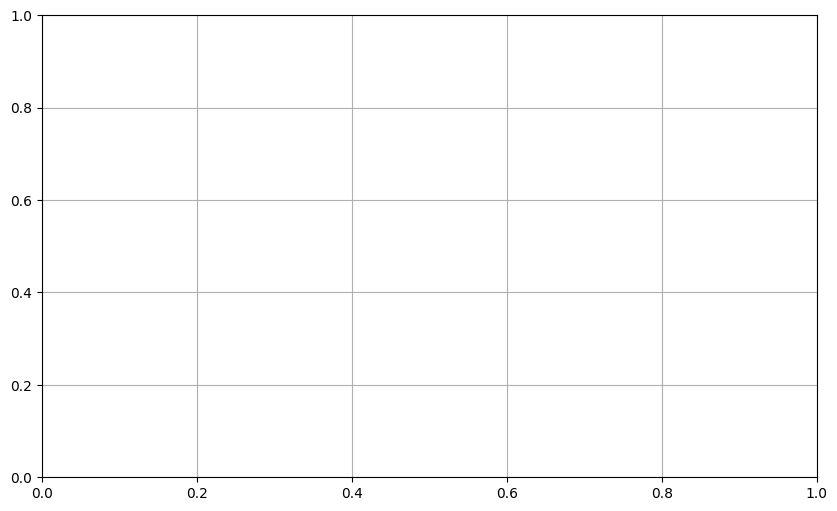

In [52]:
plt.figure(figsize=figsize)
plt.grid()
for i, filename in enumerate(filenames):
    print("\n", i, filename)
    plot_file(i, only50=True)
plt.show()

plt.figure(figsize=figsize)
plt.grid()
for i, filename in enumerate(filenames):
    print("\n", i, filename)
    plot_file(i, only99=True)
plt.show()